# Explore here

In [193]:
# Your code here
import pandas as pd
import regex as re
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from unidecode import unidecode
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
import string  
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV
import joblib









[nltk_data] Downloading package punkt to /home/vscode/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/vscode/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /home/vscode/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/vscode/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [184]:
df = pd.read_csv("https://raw.githubusercontent.com/4GeeksAcademy/NLP-project-tutorial/main/url_spam.csv")
df.head()

,url,is_spam
0,https://briefingday.us8.list-manage.com/unsubs...,True
1,https://www.hvper.com/,True
2,https://briefingday.com/m/v4n3i4f3,True
3,https://briefingday.com/n/20200618/m#commentform,False
4,https://briefingday.com/fan,True


Procesamiento de datos

In [185]:
#vategoricas num : 

df["is_spam"] = df["is_spam"].apply(lambda x: 1 if x == True else 0).astype(int)
df.head()

,url,is_spam
0,https://briefingday.us8.list-manage.com/unsubs...,1
1,https://www.hvper.com/,1
2,https://briefingday.com/m/v4n3i4f3,1
3,https://briefingday.com/n/20200618/m#commentform,0
4,https://briefingday.com/fan,1


In [186]:
#Eliminar valores repetidas : 
print(df.shape)

df = df.drop_duplicates()
df = df.reset_index(inplace = False, drop = True)


#Ver cuantas filas se eliminó balance del df spam vs no spam:
print(df.shape)
print(f"Spam: {len(df.loc[df.is_spam == 1])}")
print(f"No spam: {len(df.loc[df.is_spam == 0])}")


(2999, 2)
(2369, 2)
Spam: 244
No spam: 2125


Procesamiento de datos :

In [187]:
def preprocess_url(url):
    #Convertir a minúsculas
    url = url.lower()
    
    #Eliminar "http", "https", "www"... si existen
    url = re.sub(r"^https?://(www\.)?", '', url)
    url = re.sub(r'\b(com|html|net)\b', '', url)
    
    #Verificar que la URL no esté vacía después de la eliminación 
    if not url:
        return []

    #Dividir la URL en partes usando '/' como delimitador
    parts = url.split('/')

    #Tokenización de las partes de la URL
    tokens = []
    for part in parts:
        part_tokens = word_tokenize(part)  # Divide cada parte en palabras
        tokens.extend(part_tokens)
    
    #Eliminar stopwords
    stop_words = set(stopwords.words('english'))  
    stop_words.update(['com', 'org', 'html', 'net', 'gov', 'edu', 'us', 'co'])  # Aseguramos que no eliminamos palabras clave
    
    #Limpiar y eliminar palabras que coincidan con los stopwords (asegurando que no tengan puntuación)
    tokens = [token for token in tokens if unidecode(token.strip(string.punctuation)) not in stop_words]  
    
    #Eliminar puntuación de los tokens
    tokens = [unidecode(token.strip(string.punctuation)) for token in tokens]

    
    #Eliminar los acentos si quedan
    tokens = [unidecode(token) for token in tokens]
    
    #Lematización = transforma una palabra en su forma base
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    #Eliminar palabras de longitud 1 o menos, que son poco significativas
    tokens = [token for token in tokens if len(token) > 2]
    
    return tokens 

#Aplicar la función al df
df['processed_url'] = df['url'].apply(preprocess_url)

#Verificar el resultado
print(df['processed_url'].head())


0    [briefingday.us8.list-manage, unsubscribe]
1                                       [hvper]
2                       [briefingday, v4n3i4f3]
3          [briefingday, 20200618, commentform]
4                            [briefingday, fan]
Name: processed_url, dtype: object


Total de palabras encontradas: 1113


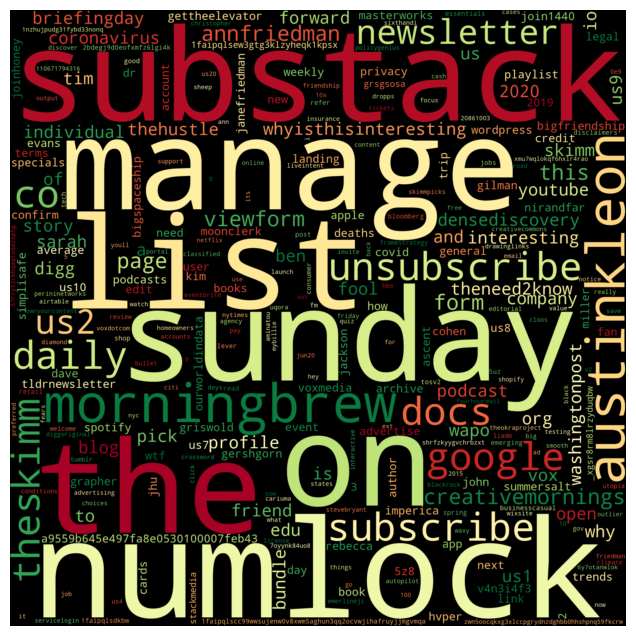

In [188]:
#Nube de palabras solo de filas que son spams :

spam_df = df[df['is_spam'] == 1]
text = ' '.join(spam_df['processed_url'].dropna().apply(lambda x: ' '.join(x)))  #Unir cada lista de palabras en una cadena

#Contar la frecuencia de palabras
words = re.findall(r'\w+', text.lower())  #Convertir todas las palabras a minúsculas
print(f"Total de palabras encontradas: {len(words)}")  #Verifica cuántas palabras se han encontrado

#Si hay palabras, proceder a generar la nube de palabras
if words:
    word_freq = Counter(words)
    wordcloud = WordCloud(width=2000, height=2000, 
                          background_color='black', 
                          max_words=300,
                          min_font_size=20,
                          colormap='RdYlGn',
                          contour_width=0.4,
                          contour_color='black',
                          relative_scaling=0, 
                          random_state=42).generate_from_frequencies(word_freq)
    
    fig = plt.figure(figsize=(8, 8), facecolor=None)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()
else:
    print("No hay palabras suficientes para generar la nube de palabras.")

In [189]:
#Vectorización de las URLs
tokens_list = df["processed_url"]
tokens_list = [" ".join(tokens) for tokens in tokens_list]

vectorizer = TfidfVectorizer(max_features=5000, max_df=0.8, min_df=5)
X = vectorizer.fit_transform(tokens_list).toarray()
y = df["is_spam"]

# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f"Conjunto de entrenamiento: {len(X_train)} muestras")
print(f"Conjunto de prueba: {len(X_test)} muestras")

print(X_train[:5])
print(y_train[:5])

Conjunto de entrenamiento: 1658 muestras
Conjunto de prueba: 711 muestras
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
483     1
2004    0
277     0
1552    0
221     0
Name: is_spam, dtype: int64


Construye SVC 

In [190]:
#Crear el modelo SVM con parámetros por defecto
svm_model = SVC()

#Entrenar el modelo
svm_model.fit(X_train, y_train)

#Hacer predicciones
y_pred = svm_model.predict(X_test)

#Evaluar el modelo
print("Reporte de clasificación:")
print(classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       641
           1       0.95      0.56      0.70        70

    accuracy                           0.95       711
   macro avg       0.95      0.78      0.84       711
weighted avg       0.95      0.95      0.95       711

Accuracy: 0.9535864978902954


Precisión del 95% en la identificación de url no spam, pero el modelo tiene dificultades para identificar bien los spams, con un recall del 56% para la clase de spam.
Tambien se refleja en un F1-score de 0.70 para la clase de spam.

In [191]:
#Optimización donc Gridsearch :  buscar los mejores hiperparámetros

#Definir los hiperparámetros a optimizar - 
param_grid = {
    'C': [0.1, 1, 10, 100], #Parámetro de Regularización:controla el equilibrio entre maximizar el margen y minimizar el error de clasificación
    'gamma': [1, 0.1, 0.01, 0.001], #Coeficiente del Kernel RBF, Poly, Sigmoid
    'kernel': ['rbf', 'poly', 'sigmoid'] #Kernel transforma los datos en un espacio de mayor dimensión donde un clasificador lineal puede separarlos.
}

#Valores elegidas: xque cubren una gama de posibles comportamientos del modelo, desde modelos altamente regulares con márgenes amplios y errores permitidos, hasta modelos más complejos que intentan clasificar perfectamente el conjunto de datos de entrenamiento.

#Crear el modelo SVM
svm = SVC()

#Configurar el GridSearchCV
grid_search = GridSearchCV(svm, param_grid, refit=True, verbose=2)
grid_search.fit(X_train, y_train)

#Obtener los mejores parámetros
print("Mejores parámetros encontrados:")
print(grid_search.best_params_)



Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.2s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.2s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.2s


[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.2s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.2s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.2s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.2s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.2s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.3s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.2s
[CV] END .....................C=0.1, gamma=1, kernel=sigmoid; total time=   0.1s
[CV] END .....................C=0.1, gamma=1, kernel=sigmoid; total time=   0.1s
[CV] END .....................C=0.1, gamma=1, kernel=sigmoid; total time=   0.1s
[CV] END .....................C=0.1, gamma=1, kernel=sigmoid; total time=   0.1s
[CV] END .....................C=0.1, gamma=1, kernel=sigmoid; total time=   0.1s
[CV] END ...................

In [192]:
#Evaluar el modelo optimizado
y_pred_optimized = grid_search.predict(X_test)
print("Reporte de clasificación (modelo optimizado):")
print(classification_report(y_test, y_pred_optimized))
print(f"Accuracy (modelo optimizado): {accuracy_score(y_test, y_pred_optimized)}")

Reporte de clasificación (modelo optimizado):
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       641
           1       0.95      0.60      0.74        70

    accuracy                           0.96       711
   macro avg       0.96      0.80      0.86       711
weighted avg       0.96      0.96      0.95       711

Accuracy (modelo optimizado): 0.9578059071729957


El modelo optimizado muestra una pequeña mejora en la precisión general, aumentando del 95% al 96%.
El F1-score para la clase de spam mejora de 0.70 a 0.74, indicando una mejor combinación de precisión y recall para identificar spams.
El recall para la clase de spam también mejora del 56% al 60%, sugiriendo que el modelo optimizado es más efectivo en la detección de spam

Guardar el modelo :

In [194]:

# Guardar el modelo optimizado
joblib.dump(grid_search.best_estimator_, '/workspaces/pauline---machine-learning-python-template/models/svm_spam_model.pkl')

# Para cargar el modelo en el futuro
# loaded_model = joblib.load('/workspaces/pauline---machine-learning-python-template/models/svm_spam_model.pkl')

['/workspaces/pauline---machine-learning-python-template/models/svm_spam_model.pkl']